<a href="https://colab.research.google.com/github/Susanna-Salata/Sigma-University/blob/main/Sigma_HW_4_WS_1_Susanna_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Інформація про датасет

**Інформація про набір даних:**<br>
Набір даних містить 9358 усереднених за годину відповідей від масиву з 5 хімічних датчиків оксиду металу, вбудованих у хімічний мультисенсорний пристрій якості повітря. Апарат був розташований на полі в сильно забрудненому районі, на рівні дороги, в межах італійського міста. Дані були записані з березня 2004 р. по лютий 2005 р. (один рік), що представляє собою найдовші доступні у вільному доступі записи відповідей хімічних датчиків якості повітря, розміщених у полі. Ground Truth усереднені за годину концентрації CO, неметанових вуглеводнів, бензолу, загальних оксидів азоту (NOx) і діоксиду азоту (NO2) були надані суміжним еталонним сертифікованим аналізатором. <br>Відсутні значення позначено значенням -200.<br>
Інформація про атрибути:<br>

0. Date - Дата (ДД/ММ/РРРР)
1. Time - Час (ГГ.ХХ.СС)
2. CO(GT) Справжня середньогодинна концентрація СО в мг/м^3 (еталонний аналізатор)
3. PT08.S1 (оксид олова) усереднена за годину відповідь датчика (номінально цільовий CO)
4. NMHC(GT) - Справжня середньогодинна загальна концентрація неметанових вуглеводнів у мкг/м^3 (еталонний аналізатор)
5. C6H6(GT) - Справжня середньогодинна концентрація бензолу в мкг/м^3 (еталонний аналізатор)
6. PT08.S2 (titania) усереднена за годину відповідь датчика (номінально націлений NMHC)
7. NOx(GT) - Справжня середньогодинна концентрація NOx в ppb (еталонний аналізатор)
8. PT08.S3 (оксид вольфраму) погодинна усереднена відповідь датчика (номінально цільовий NOx)
9. NO2(GT) - Справжня середньогодинна концентрація NO2 в мкг/м^3 (еталонний аналізатор)
10. PT08.S4 (оксид вольфраму) погодинна усереднена відповідь датчика (номінально націлений NO2)
11. PT08.S5 (оксид індію) усереднена за годину відповідь датчика (номінально цільовий O3)
12. T - Температура в °C
13. RH - Відносна вологість (%)
14. AH - Абсолютна вологість



# Ініціалізація середовища

In [1]:
# !pip install regressors

In [2]:
# init environment
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import numpy as np
import pandas as pd
import scipy.stats as st
import math
import matplotlib.text as plttxt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

from dateutil import parser

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# from regressors.stats import coef_pval
%matplotlib inline

# Зчитування і форматування даних

In [4]:

file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
resp = urlopen(file_url)
zipfile = ZipFile(BytesIO(resp.read()))
data = zipfile.open('AirQualityUCI.csv')
df = pd.read_csv(data, sep=';')

In [5]:
df.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

In [6]:
df.tail()

Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9466  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9467  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9468  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9469  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9470  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   

      PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)    T   RH   AH  \
9466           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9467           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9468           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9469           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9470           NaN      NaN           NaN          NaN  NaN  NaN  NaN   

      Unnamed: 15  Unnamed: 16  
9466          NaN          NaN  
9467          NaN          NaN  
9468          NaN          NaN  
9469          NaN          NaN  
9470          NaN          NaN

In [7]:
# check empty rows and drop them
print('Initial shape: ' + str(df.shape))
print(df[df['Date'].isnull()])
df.dropna(how='all', inplace=True)
print('Result shape: ' + str(df.shape))

Initial shape: (9471, 17)
     Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9357  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9358  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9359  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9360  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9361  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
...   ...  ...    ...          ...       ...      ...            ...      ...   
9466  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9467  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9468  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9469  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9470  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   

 

In [8]:
# check if the last 2 columns has values
[df['Unnamed: 16'].unique(),  df['Unnamed: 16'].unique()]

[array([nan]), array([nan])]

In [9]:
# drop last 2 columns
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
df.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  
0  0,7578  
1  0,7255  
2  0,7502  
3  0,7867  
4  0,7888

In [10]:
# check data
df.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

Як бачимо частина параметрів, що мала б бути числовими, такими не є. Виправимо це.

In [11]:
df['DateTime'] = (df['Date'] + ' ' + df['Time'].str.replace('.', ':')).map(parser.parse)
df['Date'] = df['Date'].map(parser.parse)
df['Hour'] = df['Time'].map(lambda x: int(x[0:2]))
df['C6H6(GT)'] = df['C6H6(GT)'].map(lambda x: float(x.replace(',','.')))
df['CO(GT)'] = df['CO(GT)'].map(lambda x: float(x.replace(',','.')))
df['T'] = df['T'].map(lambda x: float(x.replace(',','.')))
df['RH'] = df['RH'].map(lambda x: float(x.replace(',','.')))
df['AH'] = df['AH'].map(lambda x: float(x.replace(',','.')))

<ipython-input-11-8d31fdb2c5cd>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['DateTime'] = (df['Date'] + ' ' + df['Time'].str.replace('.', ':')).map(parser.parse)


In [12]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
DateTime         datetime64[ns]
Hour                      int64
dtype: object

Перевіримо основні статистики данних

In [13]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.479641   975.072032   
std     257.433866    321.993552   126.940455    467.210125   456.938184   
min    -200.000000   -200.000000  -200.000000   -200.000000  -200.000000   
25%      50.000000    637.000000    53.000000   1185.000000   700.000000   
50%     141.000000    794.000000    96.000000   1446.000000   942.000000   
75%     284.000000    960.000000   133.000000   1662.000000  1255.000000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour  
count  9357.000000  9357.000000  9357.000000  9357.000000  
mean      9.778305    39.485380    -6.837604    11.498557  
std      43.203623    51.216145    38.976670     6.923182  
min    -200.000000  -200.000000  -200.000000     0.000000  
25%      10.900000    34.100000     0.692300     5.000000  
50%      17.200000    48.600000     0.976800    11.000000  
75%      24.100000    61.900000     1.296200    18.000000  
max      44.600000    88.700000     2.231000    23.000000

За умовою, значення -200 - це пропущенні значення. Замінимо їх на nan

In [14]:
df.replace(-200, np.nan, inplace=True)

Перевіримо описові статистики

In [15]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour  
count  8991.000000  8991.000000  8991.000000  9357.000000  
mean     18.317829    49.234201     1.025530    11.498557  
std       8.832116    17.316892     0.403813     6.923182  
min      -1.900000     9.200000     0.184700     0.000000  
25%      11.800000    35.800000     0.736800     5.000000  
50%      17.800000    49.600000     0.995400    11.000000  
75%      24.400000    62.500000     1.313700    18.000000  
max      44.600000    88.700000     2.231000    23.000000

Перевіримо чи є порожні рядки (крім поля Hour)

In [16]:
df.dropna(thresh=5, inplace=True)
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour  
count  8991.000000  8991.000000  8991.000000  9326.000000  
mean     18.317829    49.234201     1.025530    11.505576  
std       8.832116    17.316892     0.403813     6.920980  
min      -1.900000     9.200000     0.184700     0.000000  
25%      11.800000    35.800000     0.736800     6.000000  
50%      17.800000    49.600000     0.995400    12.000000  
75%      24.400000    62.500000     1.313700    18.000000  
max      44.600000    88.700000     2.231000    23.000000

In [17]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'DateTime', 'Hour'],
      dtype='object')

Перевіримо розподіли

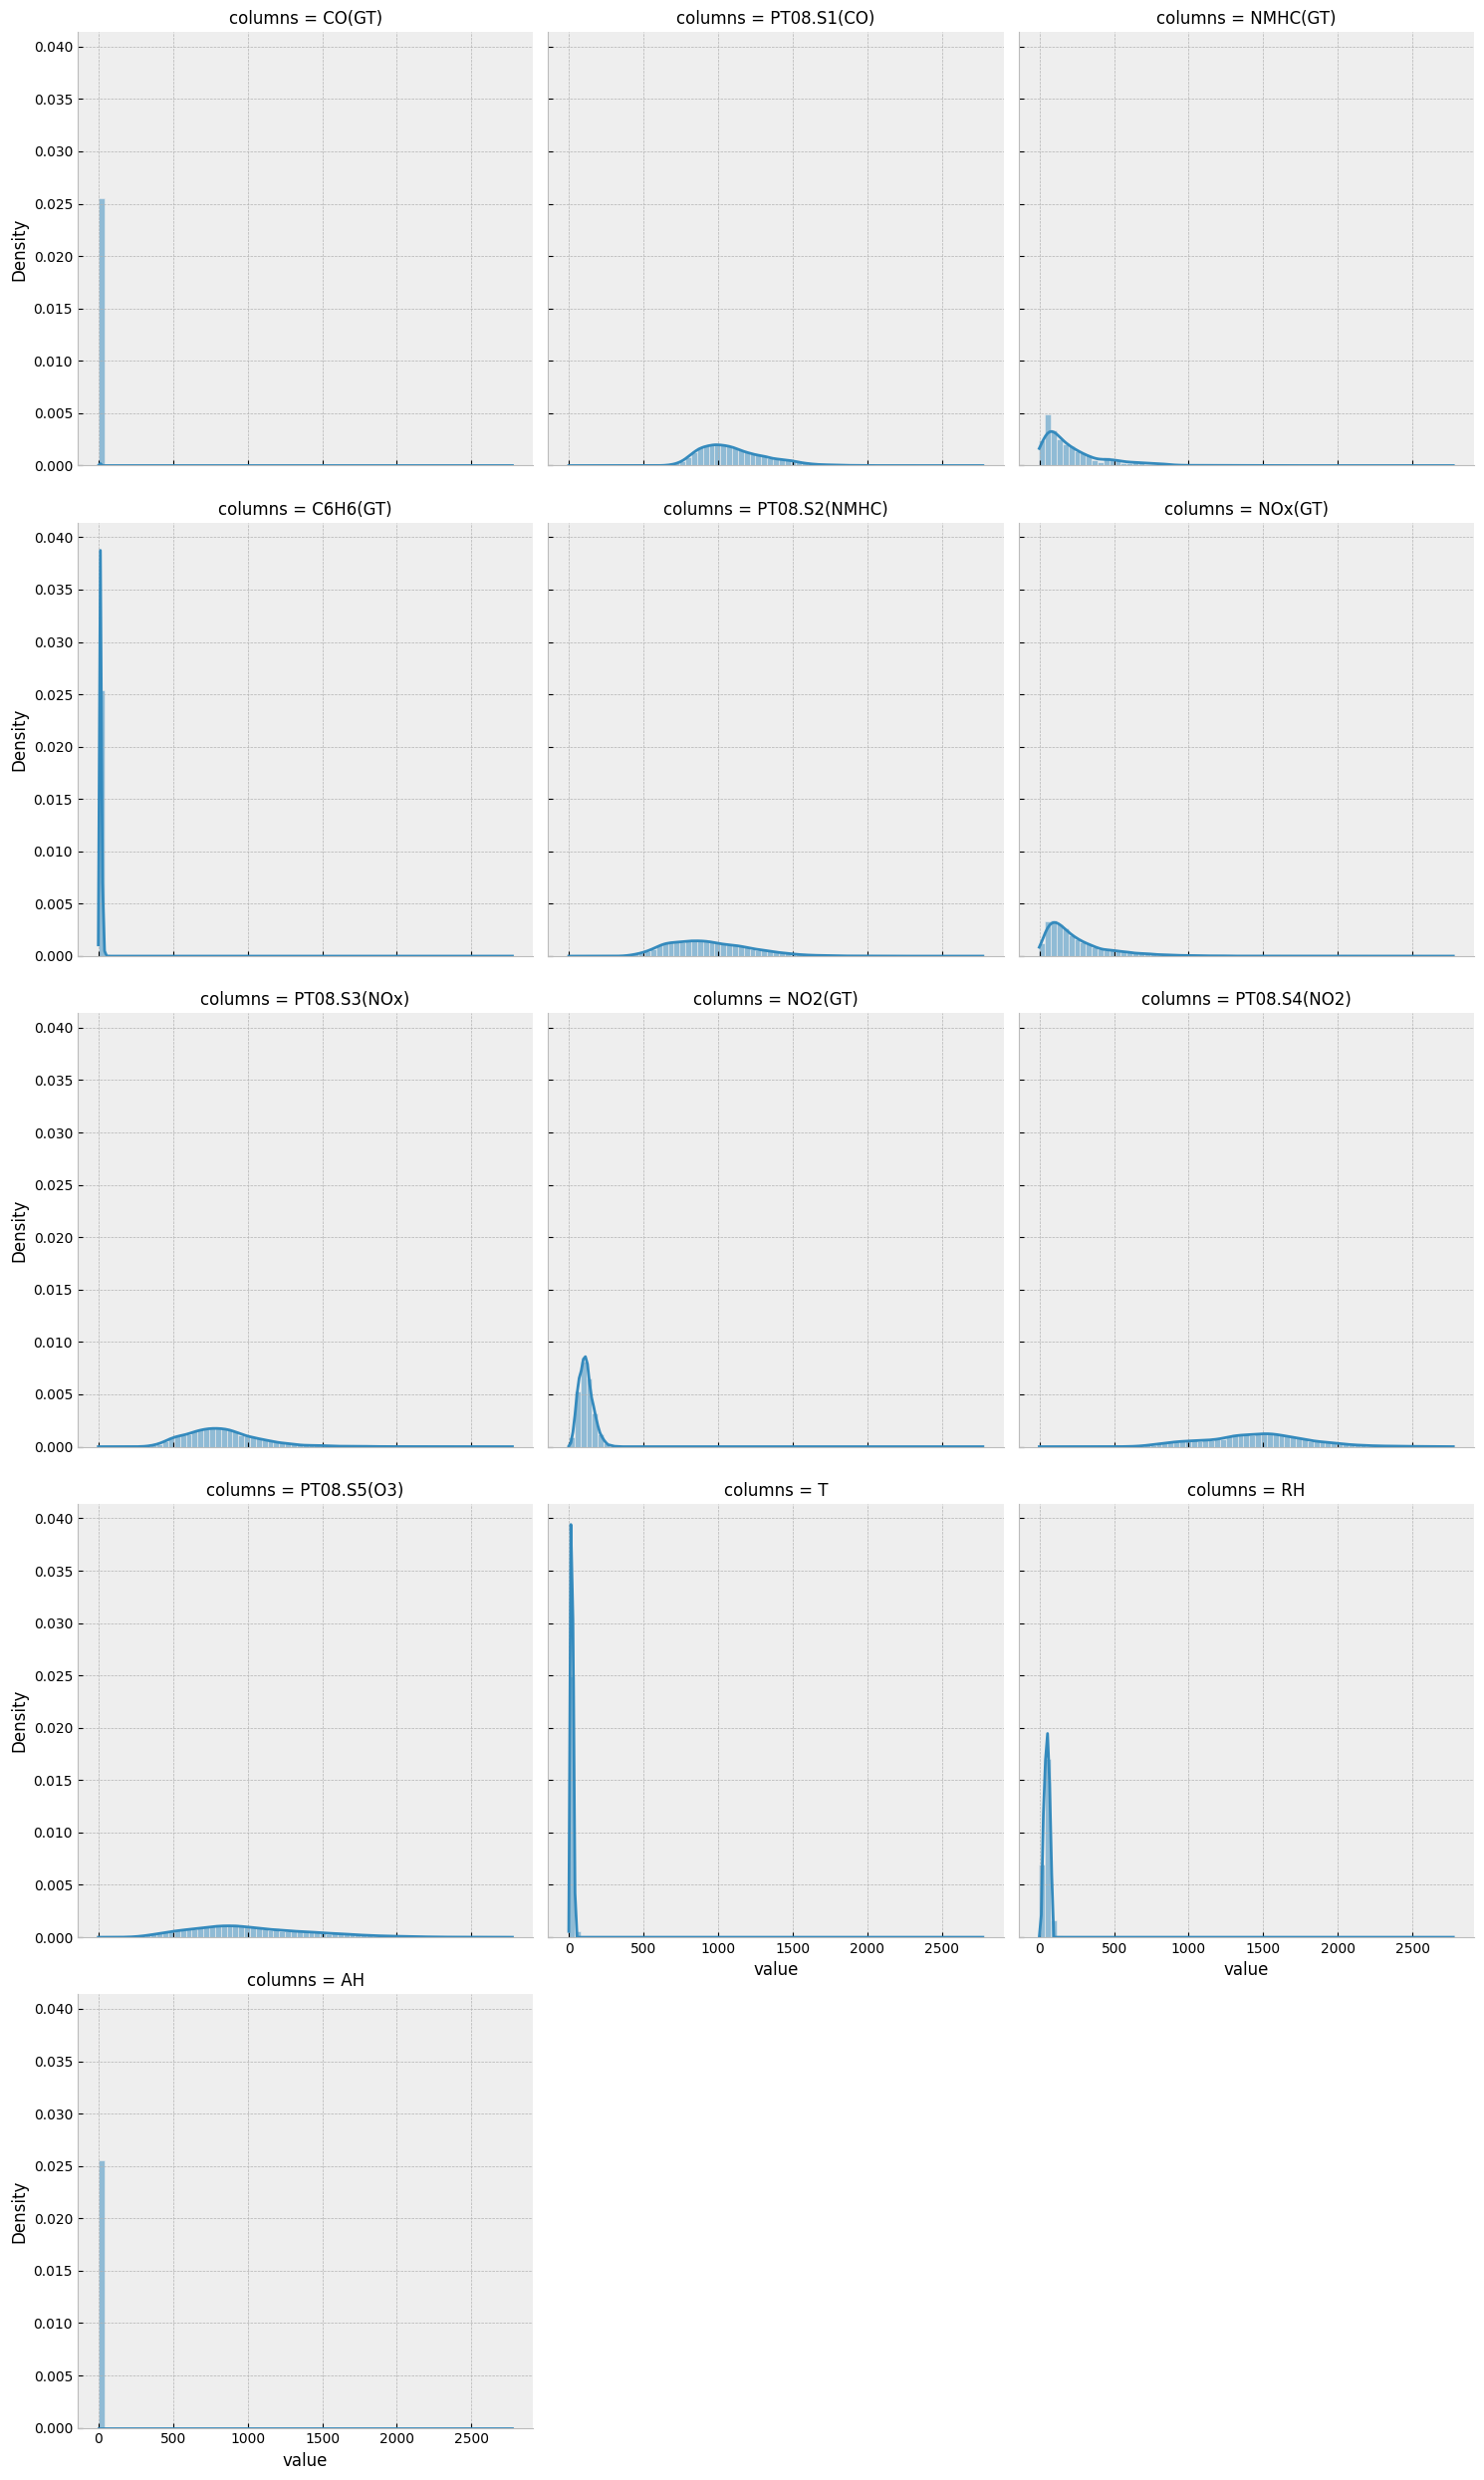

In [18]:
dfm = df.iloc[:, 2:15].melt(var_name='columns')
g = sns.displot(data=dfm, x='value', col='columns', col_wrap=3, common_norm=False, kde=True, stat='density')

In [19]:
df["CO(GT)"].fillna(value=np.median(df["CO(GT)"]), inplace=True)
#замінено на медіану

In [20]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour  
count  8991.000000  8991.000000  8991.000000  9326.000000  
mean     18.317829    49.234201     1.025530    11.505576  
std       8.832116    17.316892     0.403813     6.920980  
min      -1.900000     9.200000     0.184700     0.000000  
25%      11.800000    35.800000     0.736800     6.000000  
50%      17.800000    49.600000     0.995400    12.000000  
75%      24.400000    62.500000     1.313700    18.000000  
max      44.600000    88.700000     2.231000    23.000000

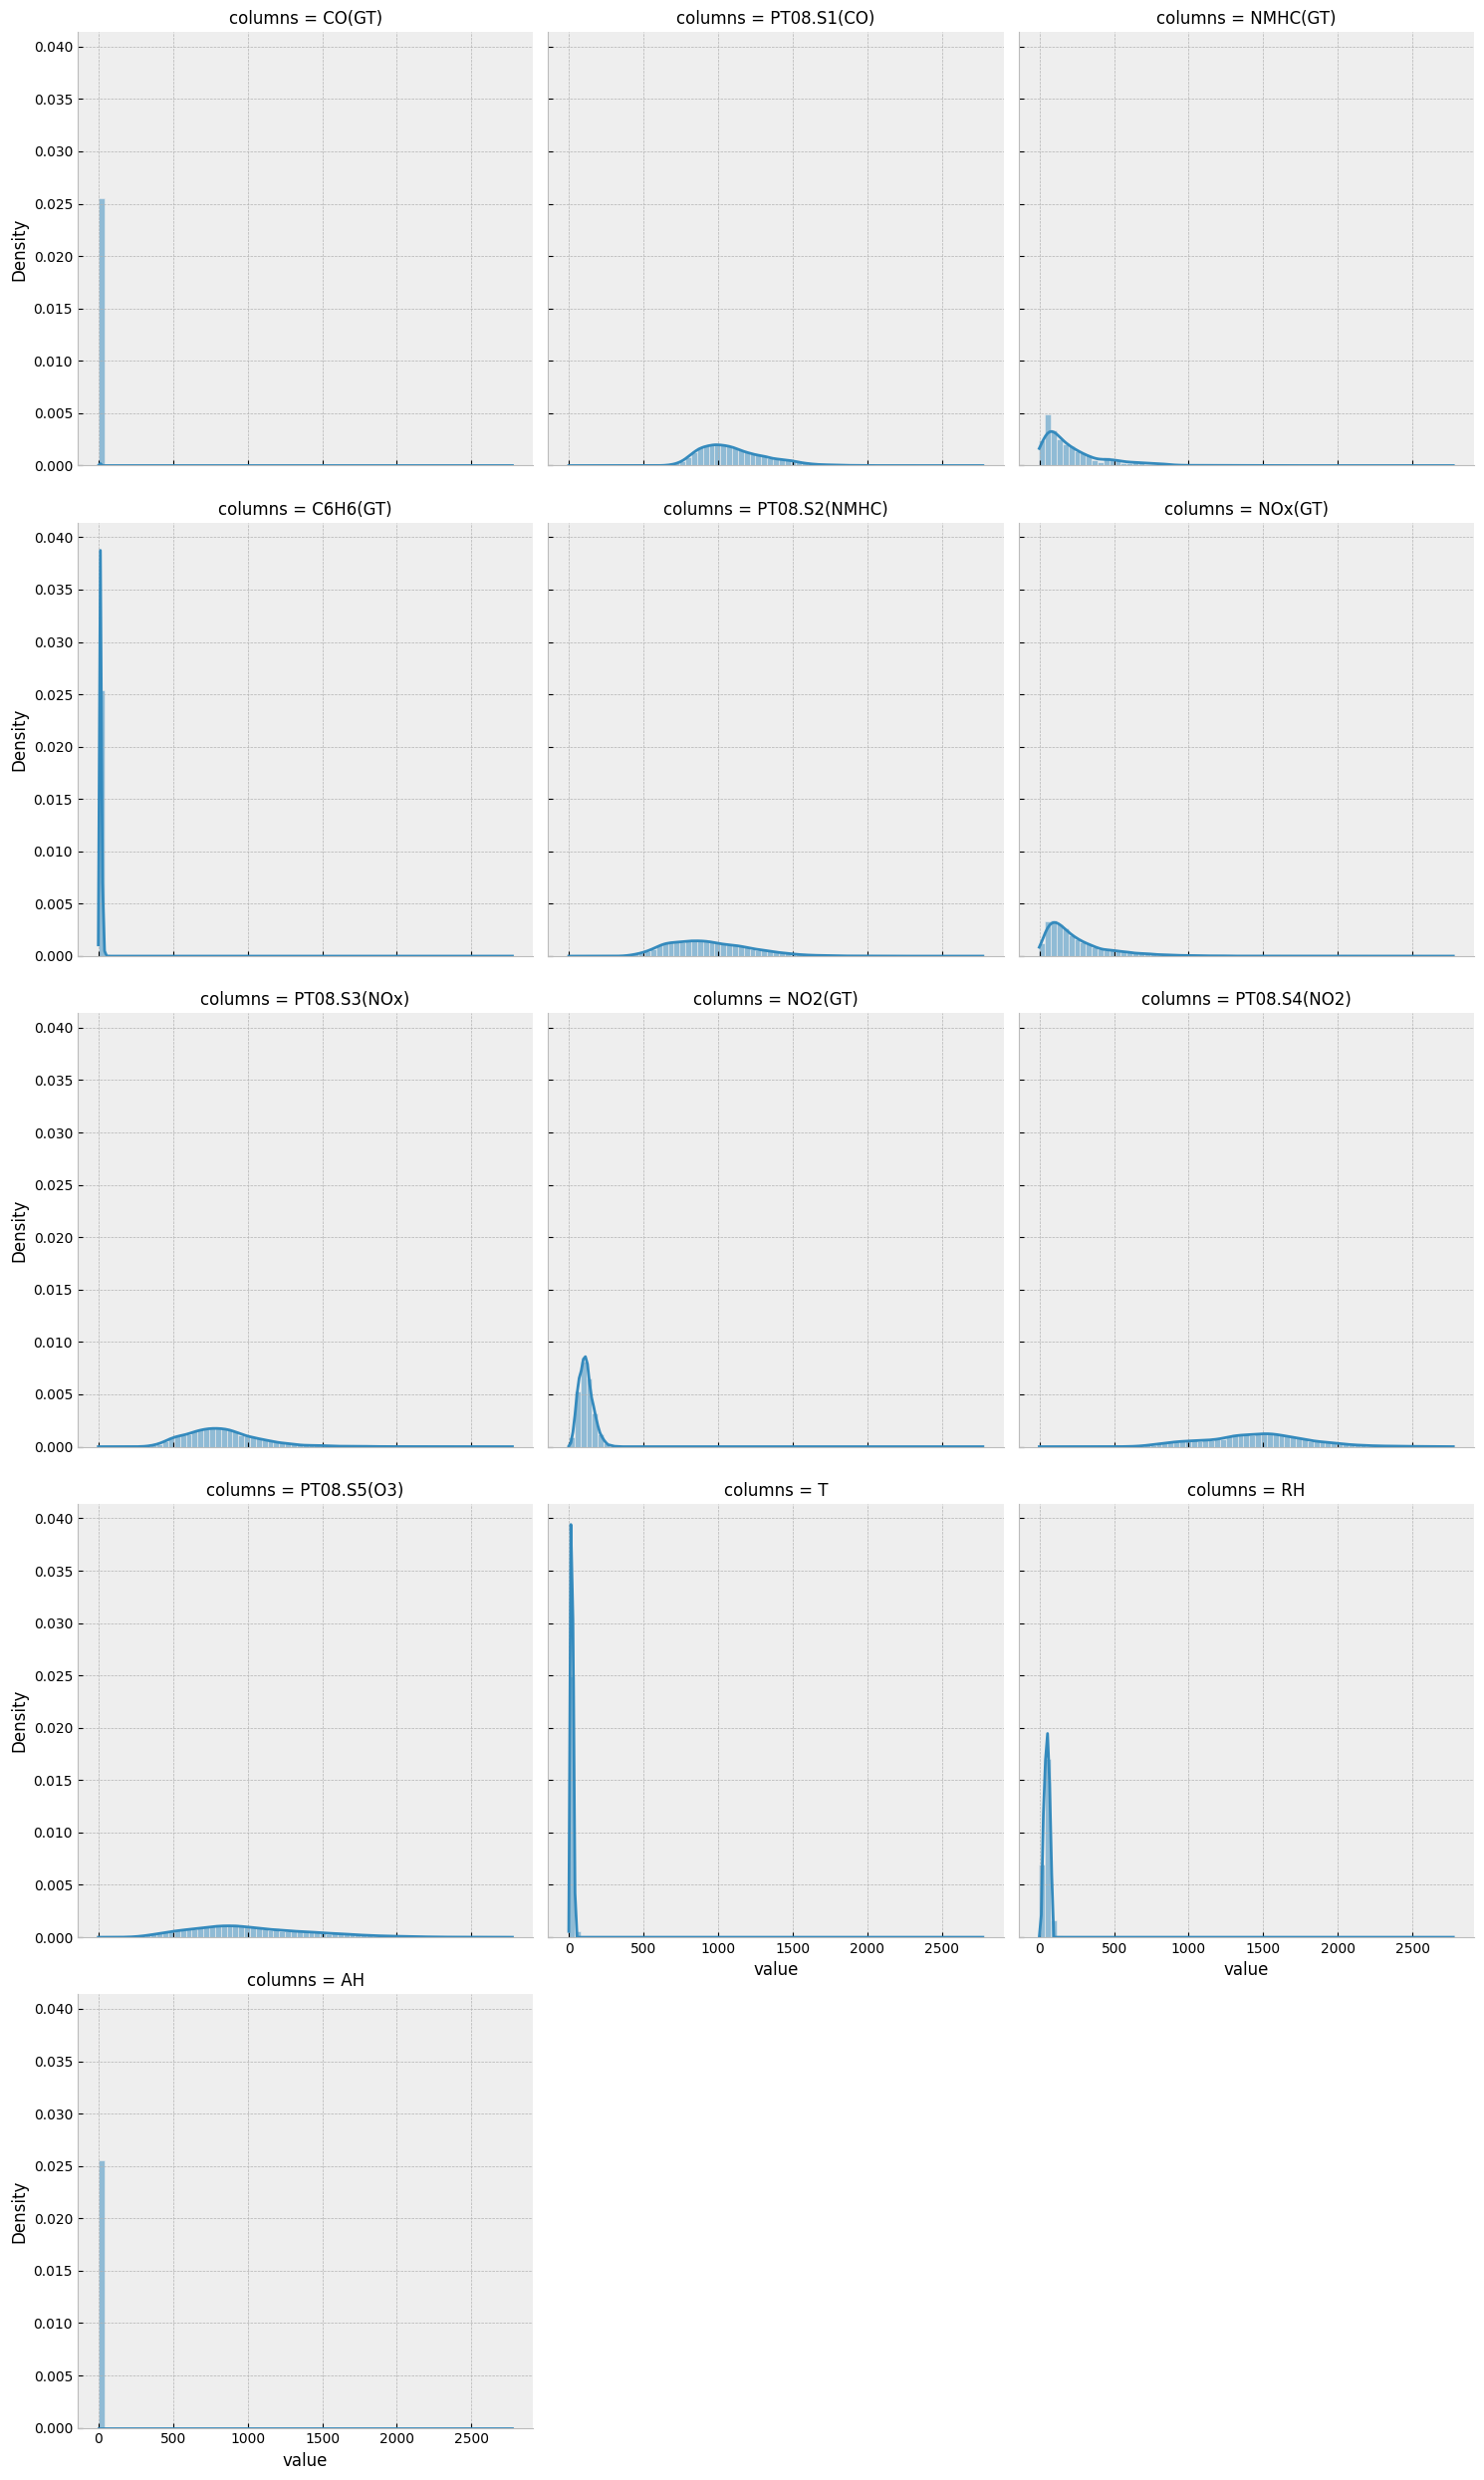

In [21]:
dfm = df.iloc[:, 2:15].melt(var_name='columns')
g = sns.displot(data=dfm, x='value', col='columns', col_wrap=3, common_norm=False, kde=True, stat='density')

In [65]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
DateTime         datetime64[ns]
Hour                      int64
Weekday                   int64
Weekday_revo              int64
Month                     int64
Month_revo                int64
dtype: object

In [66]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-10-03  18.00.00     2.6       1360.0     150.0      11.9   
1 2004-10-03  19.00.00     2.0       1292.0     112.0       9.4   
2 2004-10-03  20.00.00     2.2       1402.0      88.0       9.0   
3 2004-10-03  21.00.00     2.2       1376.0      80.0       9.2   
4 2004-10-03  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...  PT08.S5(O3)     T  \
0         1046.0    166.0        1056.0    113.0  ...       1268.0  13.6   
1          955.0    103.0        1174.0     92.0  ...        972.0  13.3   
2          939.0    131.0        1140.0    114.0  ...       1074.0  11.9   
3          948.0    172.0        1092.0    122.0  ...       1203.0  11.0   
4          836.0    131.0        1205.0    116.0  ...       1110.0  11.2   

     RH      AH            DateTime Hour  Weekday  Weekday_revo  Month  \
0  48.9  0.7578 2004-10-03 18:00:00   18        6             3     10   
1  47.7  0.7255 2004-10-03 19:00:00   19        6             3     10   
2  54.0  0.7502 2004-10-03 20:00:00   20        6             3     10   
3  60.0  0.7867 2004-10-03 21:00:00   21        6             3     10   
4  59.6  0.7888 2004-10-03 22:00:00   22        6             3     10   

   Month_revo  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 21 columns]

In [67]:
X = df.iloc[:, 2:15]
print(X.info())
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(X)

X = imputer.transform(X)
df.iloc[:, 2:15] = X
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9326 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9326 non-null   float64
 1   PT08.S1(CO)    9326 non-null   float64
 2   NMHC(GT)       9326 non-null   float64
 3   C6H6(GT)       9326 non-null   float64
 4   PT08.S2(NMHC)  9326 non-null   float64
 5   NOx(GT)        9326 non-null   float64
 6   PT08.S3(NOx)   9326 non-null   float64
 7   NO2(GT)        9326 non-null   float64
 8   PT08.S4(NO2)   9326 non-null   float64
 9   PT08.S5(O3)    9326 non-null   float64
 10  T              9326 non-null   float64
 11  RH             9326 non-null   float64
 12  AH             9326 non-null   float64
dtypes: float64(13)
memory usage: 1.2 MB
None


CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9326.000000  9326.000000  9326.000000  9326.000000    9326.000000   
mean      2.080806  1098.510079   156.743942    10.015462     938.070234   
std       1.294483   213.255277    67.168405     7.323169     262.054731   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.200000   941.000000   150.000000     4.600000     742.000000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.600000  1222.000000   150.000000    13.700000    1106.000000   
max       8.700000  2040.000000  1189.000000    63.700000    2214.000000   

          NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9326.00000   9326.000000  9326.000000   9326.000000  9326.000000   
mean    235.36232    834.434163   112.384516   1456.506541  1020.754235   
std     195.38905    252.221787    44.021078    339.933498   391.419866   
min       2.00000    322.000000     2.000000    551.000000   221.000000   
25%     112.00000    665.000000    85.000000   1241.000000   741.000000   
50%     180.00000    806.000000   109.000000   1463.000000   963.000000   
75%     285.00000    961.000000   133.000000   1662.750000  1257.000000   
max    1479.00000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour      Weekday  \
count  9326.000000  9326.000000  9326.000000  9326.000000  9326.000000   
mean     18.299228    49.247341     1.024448    11.505576     3.009329   
std       8.672554    17.003130     0.396532     6.920980     2.006696   
min      -1.900000     9.200000     0.184700     0.000000     0.000000   
25%      12.000000    36.500000     0.745500     6.000000     1.000000   
50%      17.800000    49.600000     0.995400    12.000000     3.000000   
75%      24.100000    61.900000     1.298625    18.000000     5.000000   
max      44.600000    88.700000     2.231000    23.000000     6.000000   

       Weekday_revo        Month   Month_revo  
count   9326.000000  9326.000000  9326.000000  
mean       1.718529     6.342162     2.990671  
std        1.035982     3.470491     2.006696  
min        0.000000     1.000000     0.000000  
25%        1.000000     3.000000     1.000000  
50%        2.000000     6.000000     3.000000  
75%        3.000000     9.000000     5.000000  
max        3.000000    12.000000     6.000000

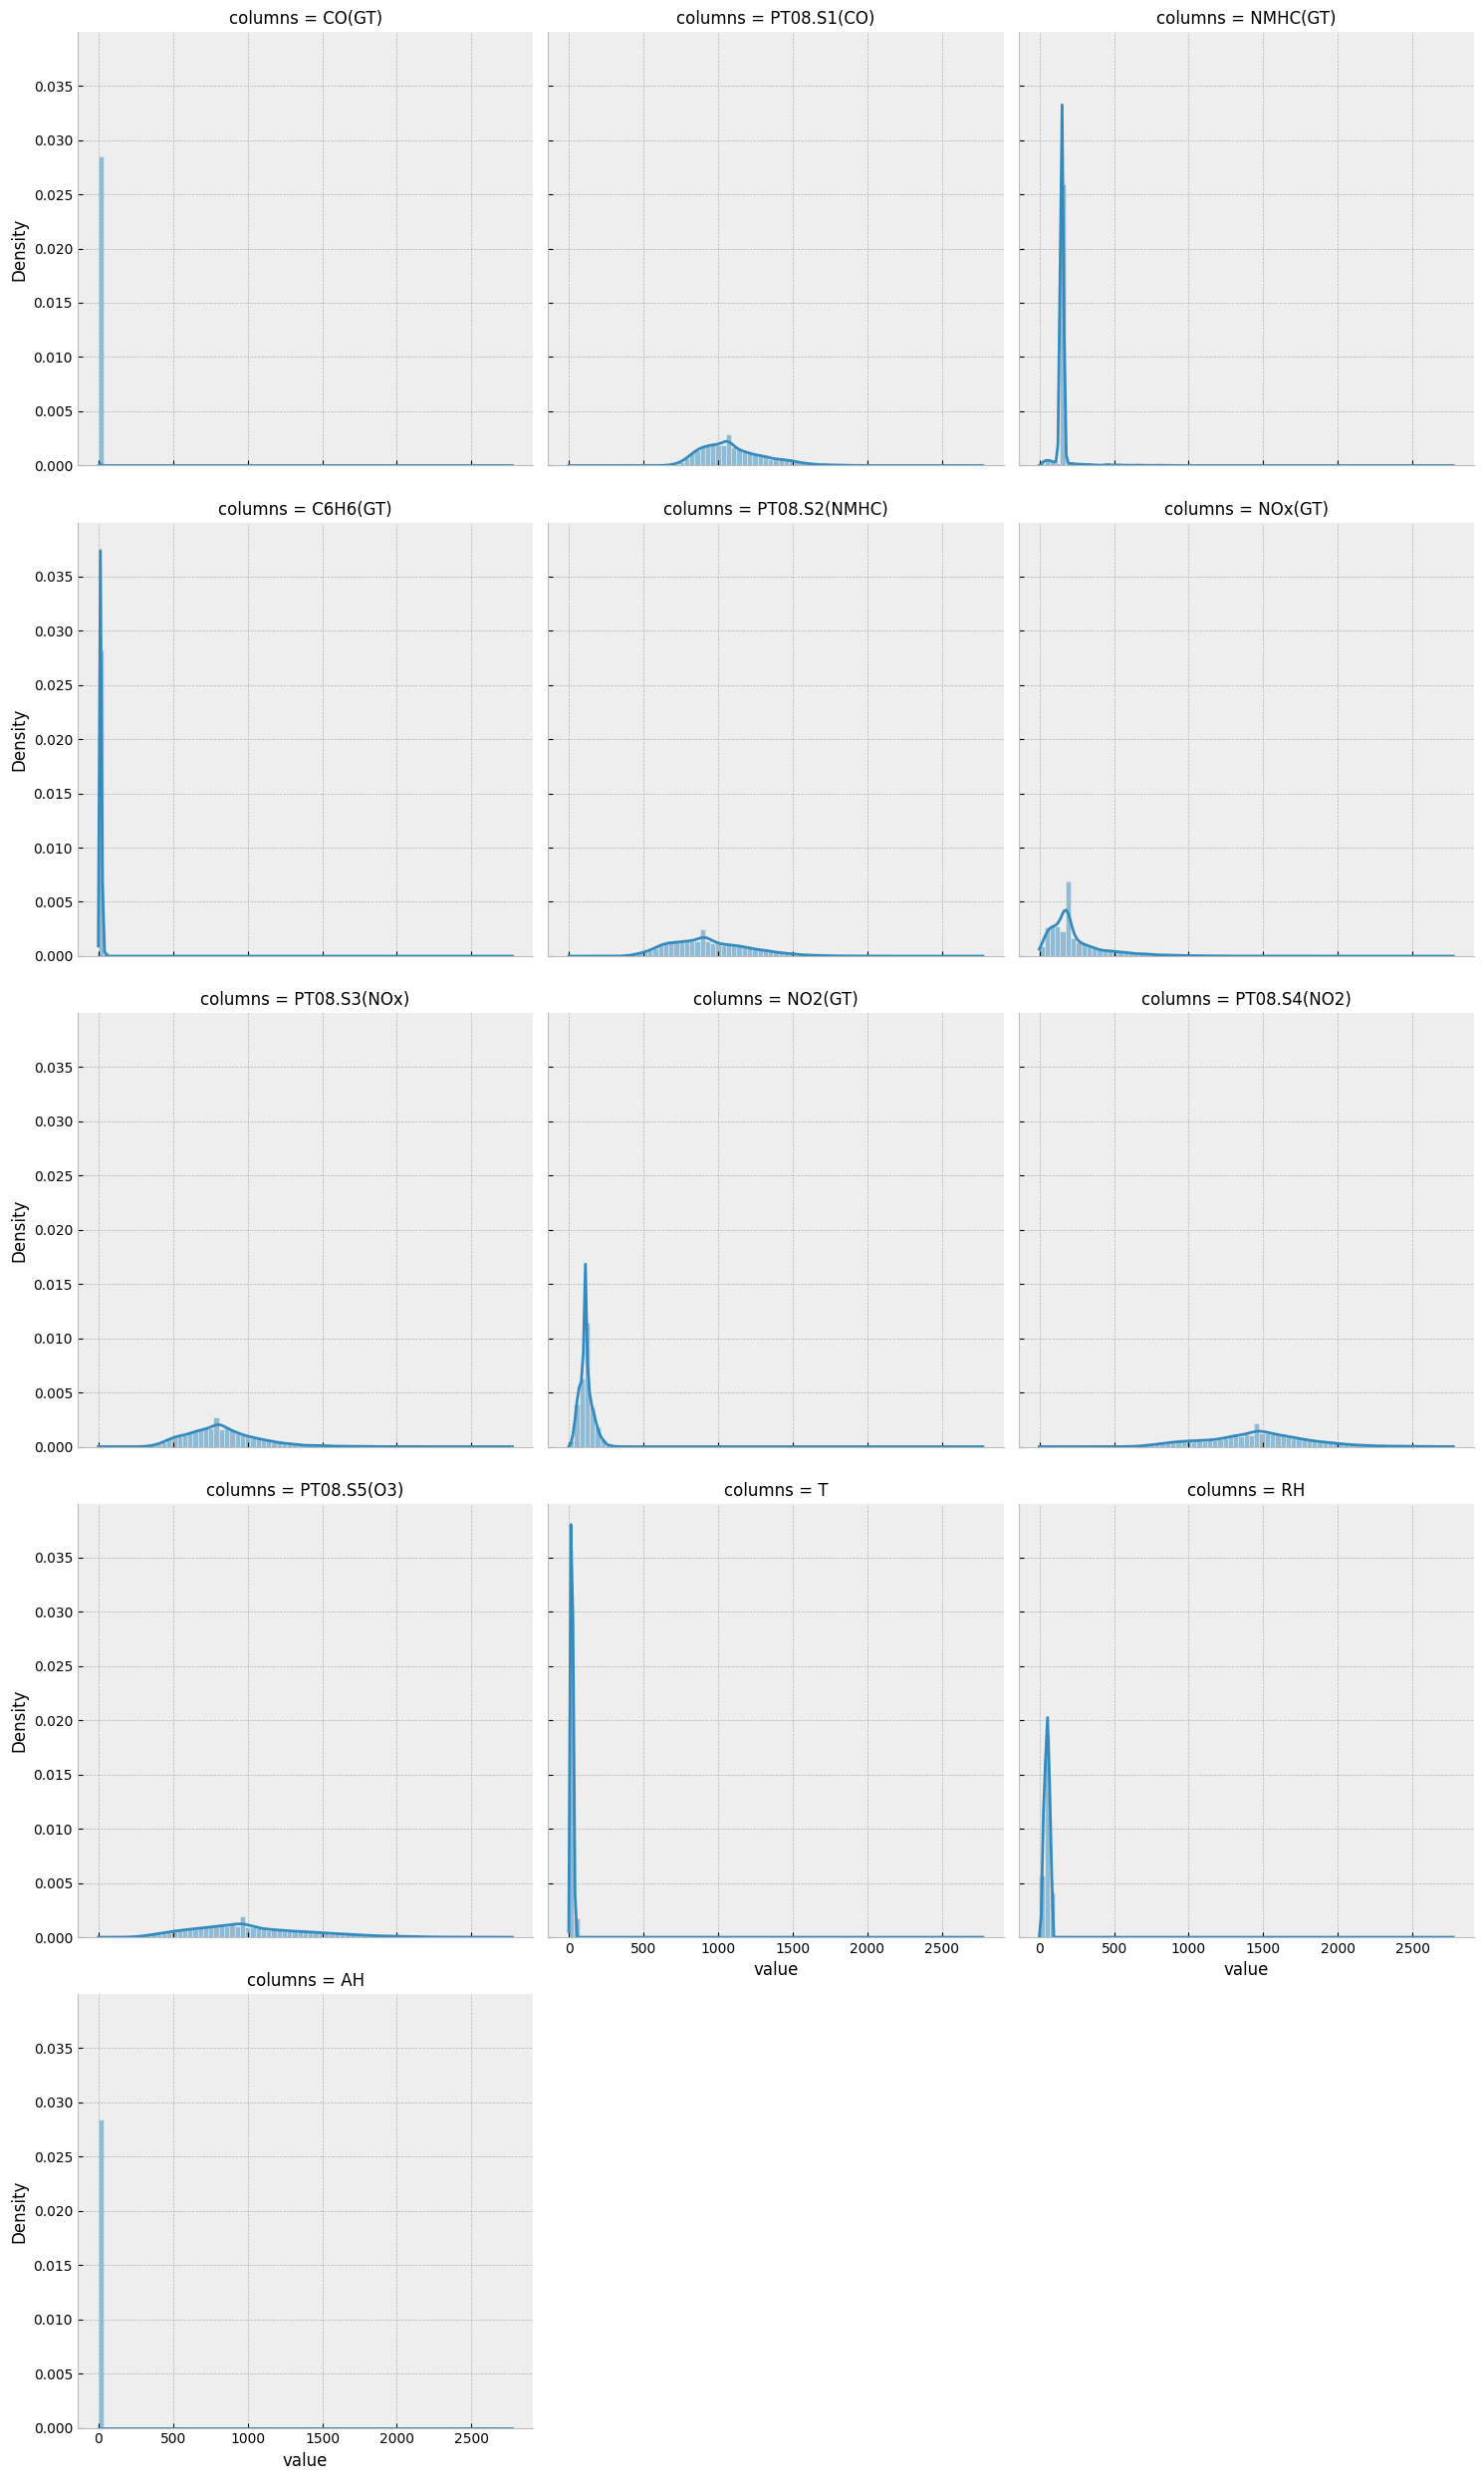

In [24]:
dfm = df.iloc[:, 2:15].melt(var_name='columns')
g = sns.displot(data=dfm, x='value', col='columns', col_wrap=3, common_norm=False, kde=True, stat='density')

# EDA

Визначемо цільовий та вхідні параметри. Цільовий C6H6(GT).

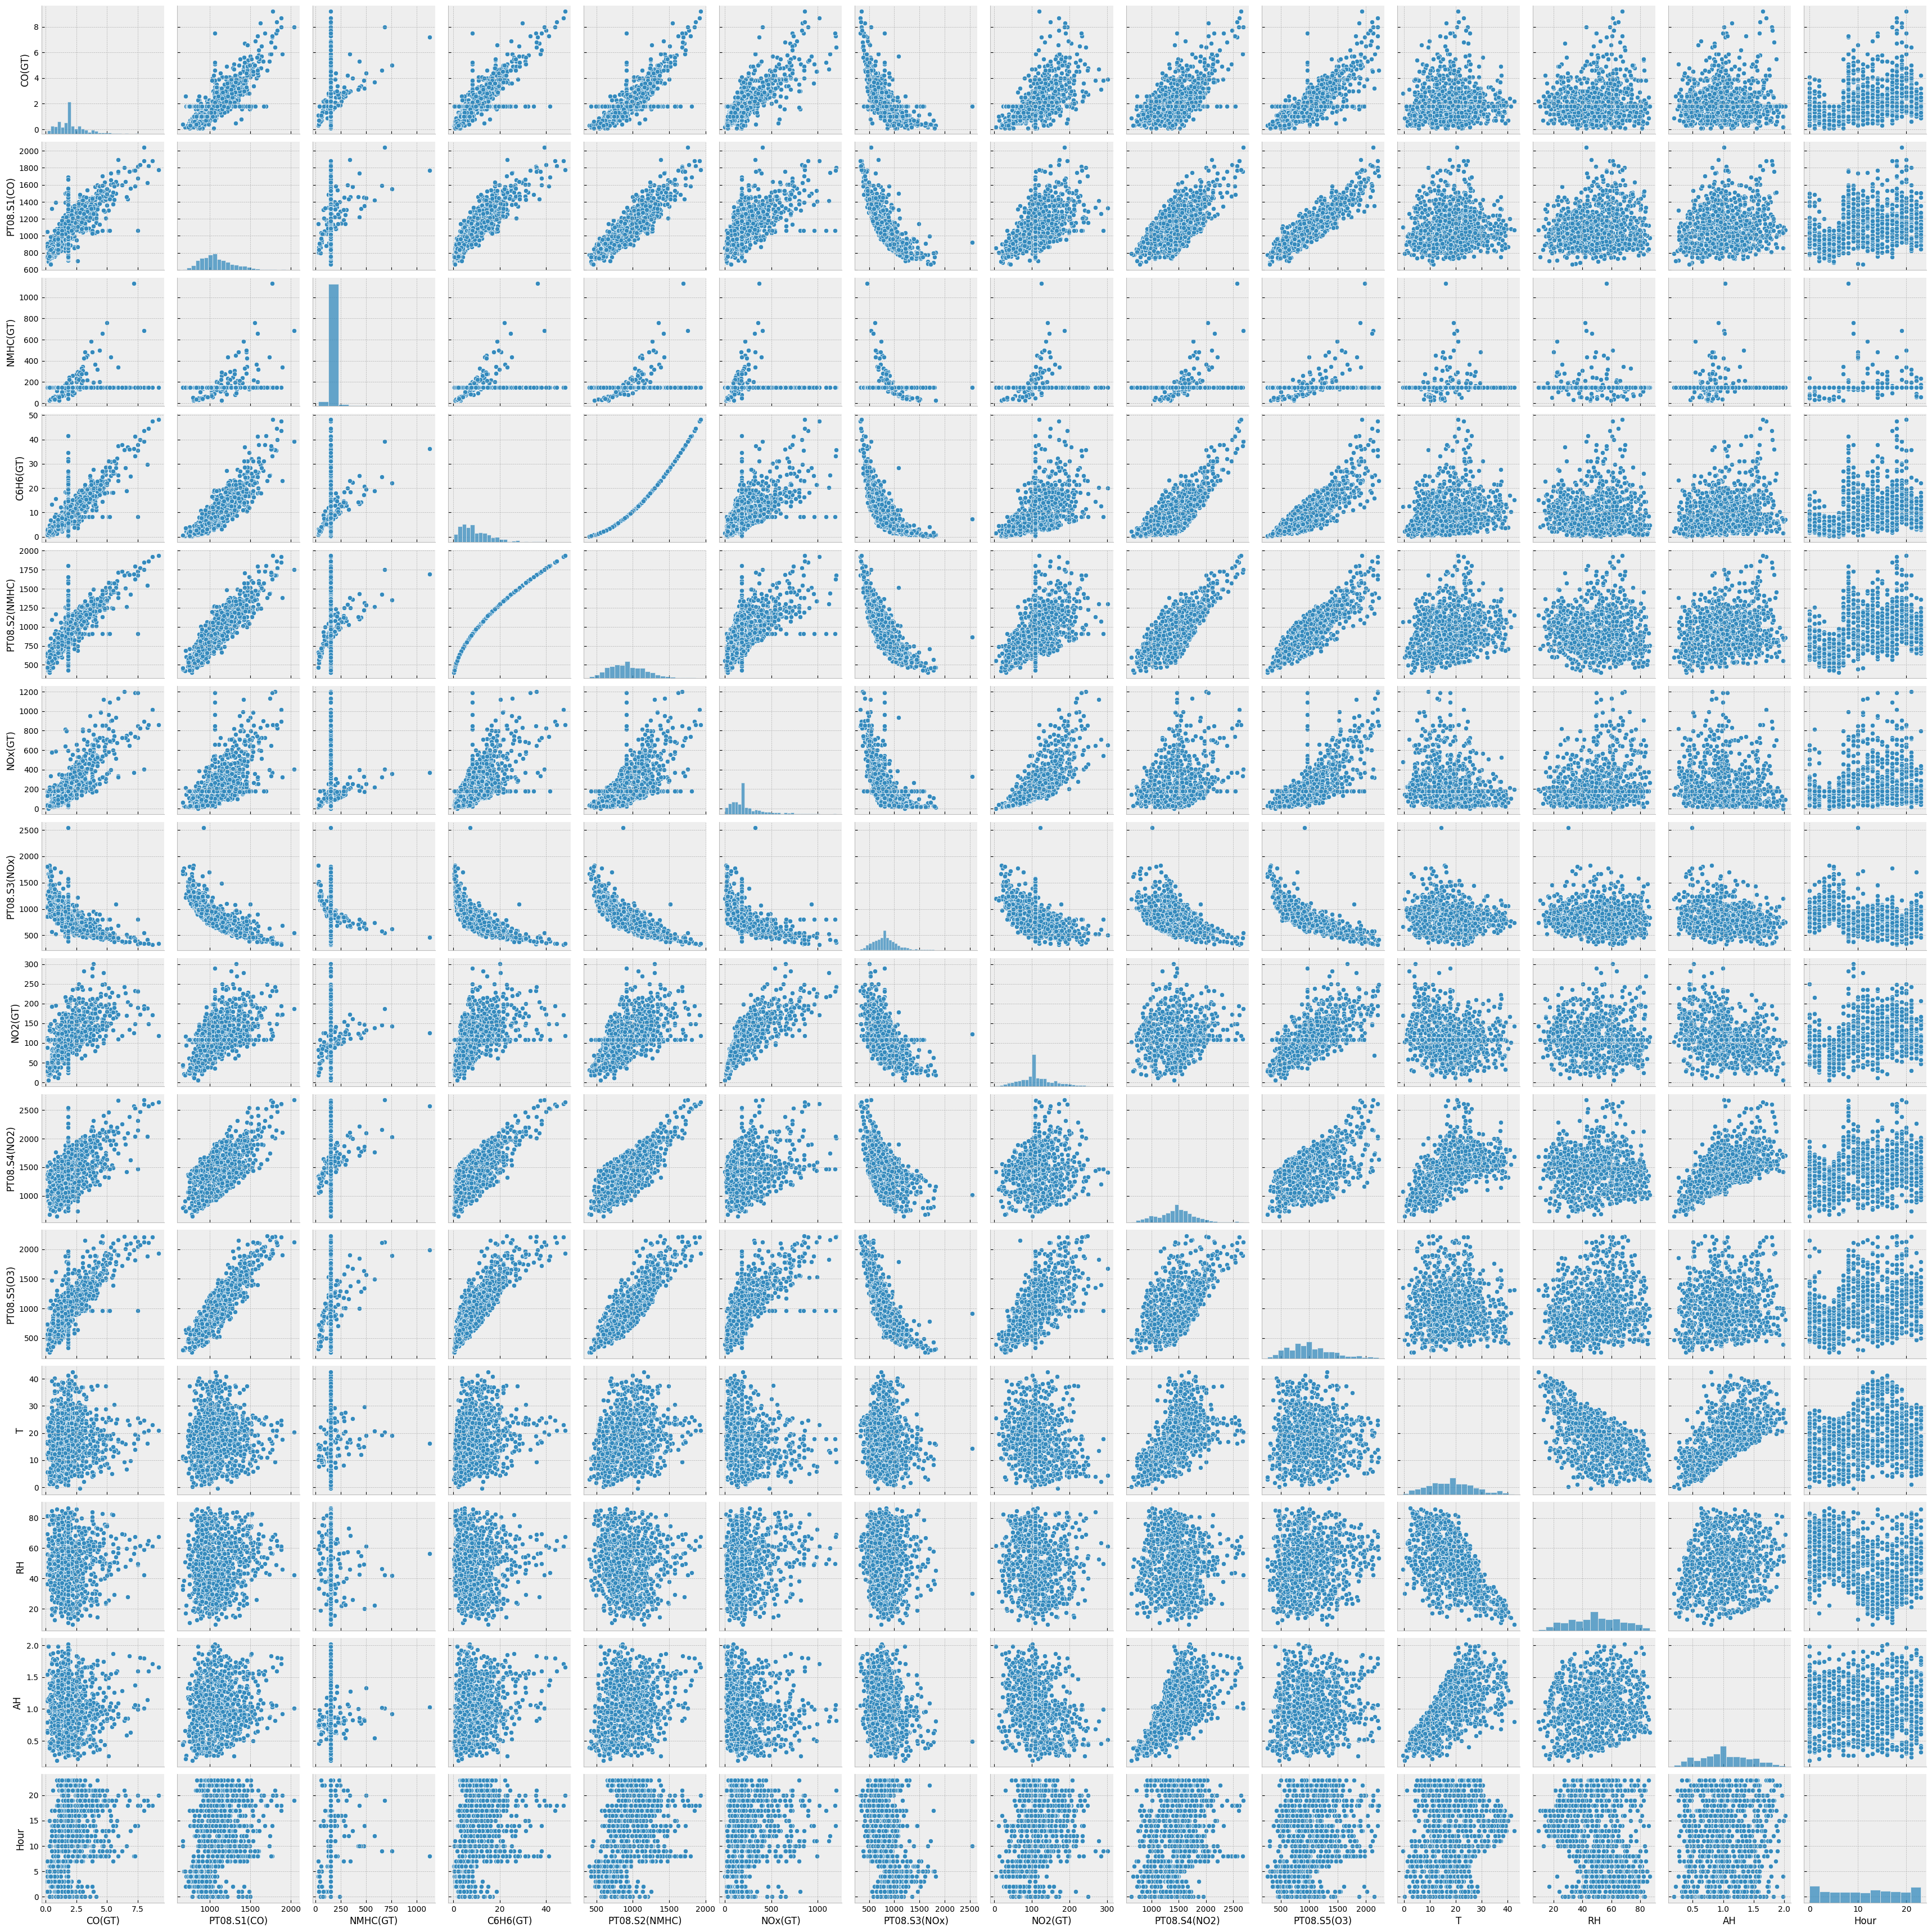

In [27]:
sns.pairplot(df.sample(n=1200))

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9326 entries, 0 to 9356
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9326 non-null   datetime64[ns]
 1   Time           9326 non-null   object        
 2   CO(GT)         9326 non-null   float64       
 3   PT08.S1(CO)    9326 non-null   float64       
 4   NMHC(GT)       9326 non-null   float64       
 5   C6H6(GT)       9326 non-null   float64       
 6   PT08.S2(NMHC)  9326 non-null   float64       
 7   NOx(GT)        9326 non-null   float64       
 8   PT08.S3(NOx)   9326 non-null   float64       
 9   NO2(GT)        9326 non-null   float64       
 10  PT08.S4(NO2)   9326 non-null   float64       
 11  PT08.S5(O3)    9326 non-null   float64       
 12  T              9326 non-null   float64       
 13  RH             9326 non-null   float64       
 14  AH             9326 non-null   float64       
 15  DateTime       9326 n

Text(0.5, 1.0, 'The relationship between CO(GT) x, C6H6(GT) y')

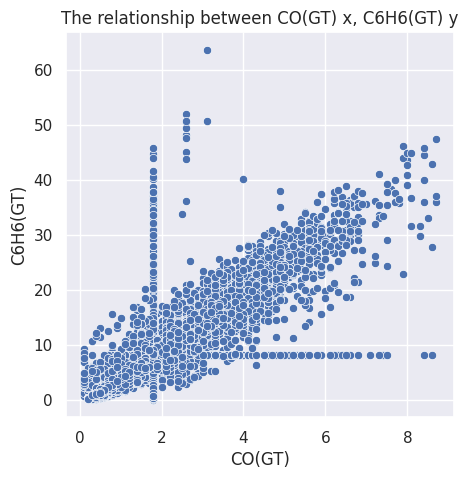

In [69]:
sns.set(rc={'figure.figsize':(5,5)})
plot_co = sns.scatterplot(data=df.loc[:, ['CO(GT)', 'C6H6(GT)']],
                          x='CO(GT)',
                          y='C6H6(GT)')
plot_co.set_title('The relationship between CO(GT) x, C6H6(GT) y')

1.3251162506989445


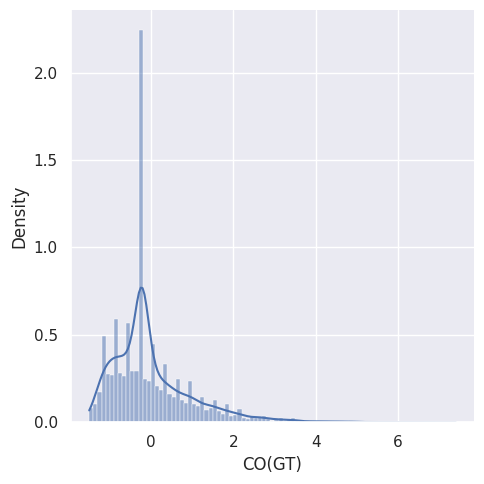

In [29]:
colname="CO(GT)"
col_sd = df[colname].std()
col_mean = df[colname].mean()
x = (df[colname] - col_mean)/col_sd
print(col_sd)
sns.displot(x=x, kde=True, stat='density', )

In [30]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9326.000000  9326.000000  9326.000000  9326.000000    9326.000000   
mean      2.090264  1098.510079   156.743942    10.015462     938.070234   
std       1.325116   213.255277    67.168405     7.323169     262.054731   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.200000   941.000000   150.000000     4.600000     742.000000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.600000  1222.000000   150.000000    13.700000    1106.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

          NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9326.00000   9326.000000  9326.000000   9326.000000  9326.000000   
mean    235.36232    834.434163   112.384516   1456.506541  1020.754235   
std     195.38905    252.221787    44.021078    339.933498   391.419866   
min       2.00000    322.000000     2.000000    551.000000   221.000000   
25%     112.00000    665.000000    85.000000   1241.000000   741.000000   
50%     180.00000    806.000000   109.000000   1463.000000   963.000000   
75%     285.00000    961.000000   133.000000   1662.750000  1257.000000   
max    1479.00000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour  
count  9326.000000  9326.000000  9326.000000  9326.000000  
mean     18.299228    49.247341     1.024448    11.505576  
std       8.672554    17.003130     0.396532     6.920980  
min      -1.900000     9.200000     0.184700     0.000000  
25%      12.000000    36.500000     0.745500     6.000000  
50%      17.800000    49.600000     0.995400    12.000000  
75%      24.100000    61.900000     1.298625    18.000000  
max      44.600000    88.700000     2.231000    23.000000

In [31]:
df[x > 5]

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
5520 2004-10-26  18.00.00     9.5       1908.0     150.0      52.1   
5690 2004-02-11  20.00.00     9.2       1778.0     150.0      48.2   
6048 2004-11-17  18.00.00    10.2       1802.0     150.0      47.7   
6192 2004-11-23  18.00.00    10.2       1982.0     150.0      49.5   
6193 2004-11-23  19.00.00    11.9       2008.0     150.0      50.6   
6194 2004-11-23  20.00.00    11.5       1918.0     150.0      49.4   
6264 2004-11-26  18.00.00    10.1       1956.0     150.0      45.2   
6409 2004-02-12  19.00.00     9.4       1816.0     150.0      43.9   
6672 2004-12-13  18.00.00     9.9       1881.0     150.0      50.8   
6696 2004-12-14  18.00.00     9.3       1063.0     150.0       8.2   
6746 2004-12-16  20.00.00     9.1       1063.0     150.0       8.2   
6914 2004-12-23  20.00.00     9.1       1701.0     150.0      36.3   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
5520         2007.0    952.0         325.0    180.0        2775.0   
5690         1935.0    859.0         349.0    119.0        2643.0   
6048         1924.0    748.0         356.0    192.0        2235.0   
6192         1959.0   1369.0         322.0    227.0        2536.0   
6193         1980.0   1389.0         325.0    220.0        2562.0   
6194         1958.0   1358.0         335.0    190.0        2477.0   
6264         1877.0   1389.0         347.0    255.0        2338.0   
6409         1851.0   1184.0         341.0    171.0        2405.0   
6672         1983.0   1479.0         334.0    269.0        2271.0   
6696          909.0   1310.0         806.0    248.0        1463.0   
6746          909.0   1253.0         806.0    219.0        1463.0   
6914         1692.0   1220.0         402.0    252.0        1832.0   

      PT08.S5(O3)     T    RH      AH            DateTime  Hour  
5520       2372.0  22.5  61.5  1.6579 2004-10-26 18:00:00    18  
5690       1927.0  20.9  67.5  1.6539 2004-02-11 20:00:00    20  
6048       2452.0  13.7  52.8  0.8244 2004-11-17 18:00:00    18  
6192       2386.0  13.2  72.6  1.0936 2004-11-23 18:00:00    18  
6193       2342.0  12.4  74.7  1.0741 2004-11-23 19:00:00    19  
6194       2237.0  11.5  76.2  1.0324 2004-11-23 20:00:00    20  
6264       2465.0  15.5  62.8  1.0979 2004-11-26 18:00:00    18  
6409       2069.0  15.4  73.0  1.2688 2004-02-12 19:00:00    19  
6672       2523.0  12.6  55.9  0.8142 2004-12-13 18:00:00    18  
6696        963.0  17.8  49.6  0.9954 2004-12-14 18:00:00    18  
6746        963.0  17.8  49.6  0.9954 2004-12-16 20:00:00    20  
6914       2415.0   6.2  56.9  0.5419 2004-12-23 20:00:00    20

In [70]:
df.loc[x > 5, "CO(GT)"] = df["CO(GT)"].quantile(q=0.85)
df[x>5]

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
5736 2004-04-11  18.00.00     3.3       1882.0     150.0      47.5   
6098 2004-11-19  20.00.00     3.3       1510.0     150.0      27.9   
6745 2004-12-16  19.00.00     3.3       1063.0     150.0       8.2   
6747 2004-12-16  21.00.00     3.3       1063.0     150.0       8.2   
6913 2004-12-23  19.00.00     3.3       1704.0     150.0      36.1   
7512 2005-01-17  18.00.00     3.3       1683.0     150.0      43.0   
7513 2005-01-17  19.00.00     3.3       1615.0     150.0      37.2   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...  PT08.S5(O3)     T  \
5736         1920.0   1014.0         328.0    171.0  ...       2204.0  23.1   
6098         1501.0    881.0         456.0    185.0  ...       1855.0  15.2   
6745          909.0   1235.0         806.0    227.0  ...        963.0  17.8   
6747          909.0   1237.0         806.0    203.0  ...        963.0  17.8   
6913         1689.0   1070.0         402.0    242.0  ...       2480.0   7.1   
7512         1831.0   1216.0         374.0    272.0  ...       2331.0   9.2   
7513         1712.0   1230.0         384.0    225.0  ...       2312.0   7.8   

        RH      AH            DateTime Hour  Weekday  Weekday_revo  Month  \
5736  61.1  1.7082 2004-04-11 18:00:00   18        6             3      4   
6098  57.5  0.9829 2004-11-19 20:00:00   20        4             1     11   
6745  49.6  0.9954 2004-12-16 19:00:00   19        3             0     12   
6747  49.6  0.9954 2004-12-16 21:00:00   21        3             0     12   
6913  50.3  0.5100 2004-12-23 19:00:00   19        3             0     12   
7512  39.3  0.4573 2005-01-17 18:00:00   18        0             3      1   
7513  48.1  0.5115 2005-01-17 19:00:00   19        0             3      1   

      Month_revo  
5736           0  
6098           2  
6745           3  
6747           3  
6913           3  
7512           6  
7513           6  

[7 rows x 21 columns]

1.282364549645345


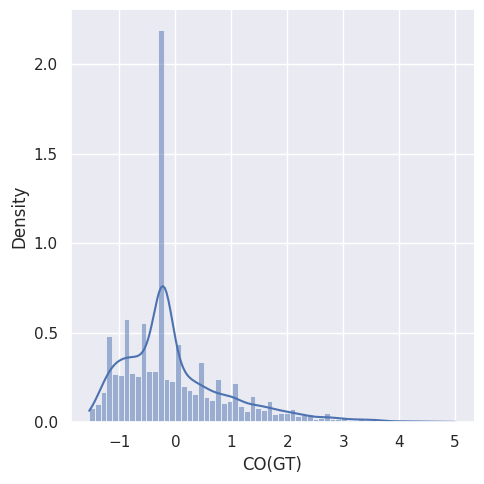

In [71]:
colname="CO(GT)"
col_sd = df[colname].std()
col_mean = df[colname].mean()
x = (df[colname] - col_mean)/col_sd
print(col_sd)
sns.displot(x=x, kde=True, stat='density', )

In [72]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-10-03  18.00.00     2.6       1360.0     150.0      11.9   
1 2004-10-03  19.00.00     2.0       1292.0     112.0       9.4   
2 2004-10-03  20.00.00     2.2       1402.0      88.0       9.0   
3 2004-10-03  21.00.00     2.2       1376.0      80.0       9.2   
4 2004-10-03  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...  PT08.S5(O3)     T  \
0         1046.0    166.0        1056.0    113.0  ...       1268.0  13.6   
1          955.0    103.0        1174.0     92.0  ...        972.0  13.3   
2          939.0    131.0        1140.0    114.0  ...       1074.0  11.9   
3          948.0    172.0        1092.0    122.0  ...       1203.0  11.0   
4          836.0    131.0        1205.0    116.0  ...       1110.0  11.2   

     RH      AH            DateTime Hour  Weekday  Weekday_revo  Month  \
0  48.9  0.7578 2004-10-03 18:00:00   18        6             3     10   
1  47.7  0.7255 2004-10-03 19:00:00   19        6             3     10   
2  54.0  0.7502 2004-10-03 20:00:00   20        6             3     10   
3  60.0  0.7867 2004-10-03 21:00:00   21        6             3     10   
4  59.6  0.7888 2004-10-03 22:00:00   22        6             3     10   

   Month_revo  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 21 columns]

# Feature Engineering

Цікавий факт: PT08.S2(NMHC) має дуже сильний квадратичний або експоненціальний звязок з C6H6(GT). <br>

<Axes: xlabel='PT08.S2(NMHC)', ylabel='C6H6(GT)'>

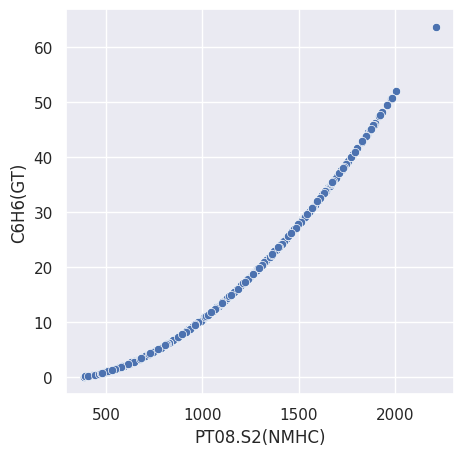

In [73]:
sns.scatterplot(x = df['PT08.S2(NMHC)'], y = df['C6H6(GT)'])

<Axes: xlabel='PT08.S2(NMHC)', ylabel='C6H6(GT)'>

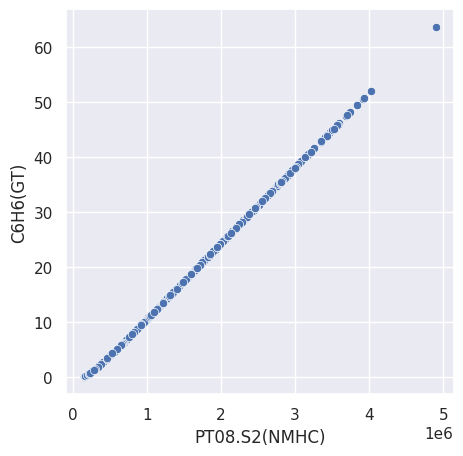

In [75]:
sns.scatterplot(x = df['PT08.S2(NMHC)']**2, y = df['C6H6(GT)'])

Давайте перевіримо кореляцію Пірсона і її p-values для квадрату PT08.S2(NMHC) і C6H6(GT)

In [76]:
st.pearsonr(df['PT08.S2(NMHC)']**2, df['C6H6(GT)'])

PearsonRResult(statistic=0.9997773201289891, pvalue=0.0)

Як бачимо, маємо майже лінійну залежність і p-value = 0, що означає, що цей звязок є значущим і лінійним. <br>
Згідно з вигомами відсутності мультиколінеарності ми не можемо використовувати квадрат PT08.S2(NMHC)<br>
В іншому випадку нам достатньо лише цього параметру, щоб прогнозувати C6H6(GT) чи наш y.

Додамо день тижня

In [77]:
df['Weekday'] = df['Date'].dt.dayofweek

PearsonRResult(statistic=-0.12306725830188943, pvalue=8.404502245384697e-33)


<Axes: xlabel='Weekday', ylabel='C6H6(GT)'>

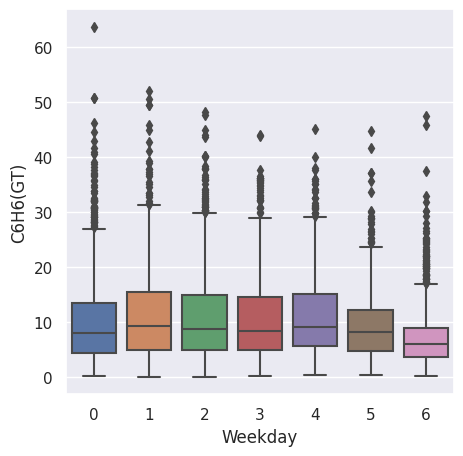

In [78]:
colname = "Weekday"
print(st.pearsonr(df[colname], df['C6H6(GT)']))
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

Додамо револьверний індекс дня тижня

In [79]:
df['Weekday_revo'] = abs(3 - df['Date'].dt.dayofweek)

PearsonRResult(statistic=-0.11258508340895877, pvalue=1.0824647942590747e-27)


<Axes: xlabel='Weekday_revo', ylabel='C6H6(GT)'>

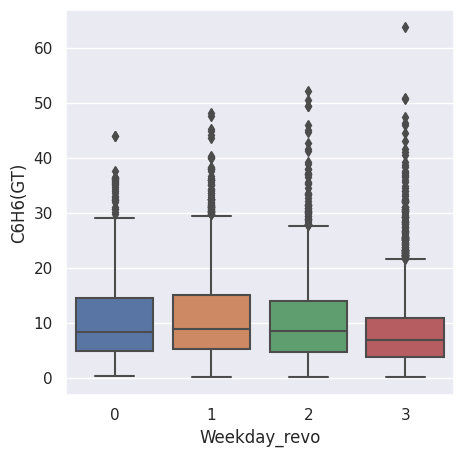

In [80]:
colname = "Weekday_revo"
print(st.pearsonr(df[colname], df['C6H6(GT)']))
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

Додамо місяць

In [81]:
df['Month'] = df['Date'].dt.month

In [82]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-10-03  18.00.00     2.6       1360.0     150.0      11.9   
1 2004-10-03  19.00.00     2.0       1292.0     112.0       9.4   
2 2004-10-03  20.00.00     2.2       1402.0      88.0       9.0   
3 2004-10-03  21.00.00     2.2       1376.0      80.0       9.2   
4 2004-10-03  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...  PT08.S5(O3)     T  \
0         1046.0    166.0        1056.0    113.0  ...       1268.0  13.6   
1          955.0    103.0        1174.0     92.0  ...        972.0  13.3   
2          939.0    131.0        1140.0    114.0  ...       1074.0  11.9   
3          948.0    172.0        1092.0    122.0  ...       1203.0  11.0   
4          836.0    131.0        1205.0    116.0  ...       1110.0  11.2   

     RH      AH            DateTime Hour  Weekday  Weekday_revo  Month  \
0  48.9  0.7578 2004-10-03 18:00:00   18        6             3     10   
1  47.7  0.7255 2004-10-03 19:00:00   19        6             3     10   
2  54.0  0.7502 2004-10-03 20:00:00   20        6             3     10   
3  60.0  0.7867 2004-10-03 21:00:00   21        6             3     10   
4  59.6  0.7888 2004-10-03 22:00:00   22        6             3     10   

   Month_revo  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 21 columns]

In [86]:
ser = pd.to_datetime(pd.Series(["2010-01-01", pd.NaT]))
ser.dt.isocalendar()

<ipython-input-86-2dbfc566a279>:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  ser = pd.to_datetime(pd.Series(["2010-01-01", pd.NaT]))


year  week   day
0  2009    53     5
1  <NA>  <NA>  <NA>

PearsonRResult(statistic=0.05895218302076753, pvalue=1.2173673026523487e-08)


<Axes: xlabel='Month', ylabel='C6H6(GT)'>

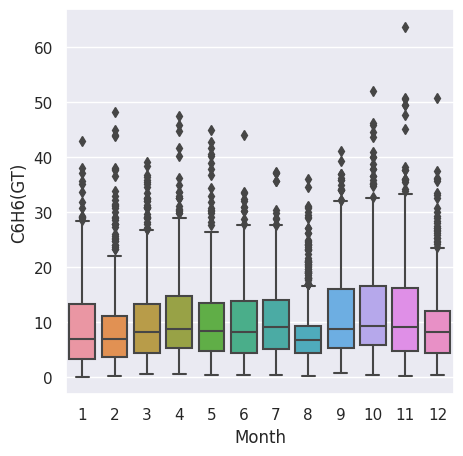

In [88]:
colname = "Month"
print(st.pearsonr(df[colname], df['C6H6(GT)']))
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

In [89]:
df['Month_revo'] = abs(6 - df['Date'].dt.dayofweek)

PearsonRResult(statistic=0.12306725830188943, pvalue=8.404502245384697e-33)


<Axes: xlabel='Month_revo', ylabel='C6H6(GT)'>

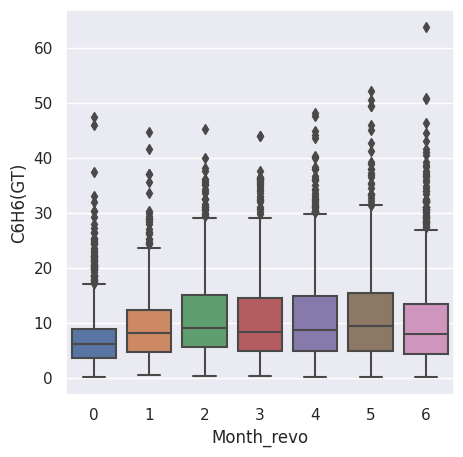

In [90]:
colname = "Month_revo"
print(st.pearsonr(df[colname], df['C6H6(GT)']))
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

Додамо сезонність: зима-літо та весна-осінь

In [92]:
def map_to_season(month):
    if month in [12, 1, 2, 6, 7, 8]:
        return 1
    else:
        return 2

df['Season'] = df['Month'].apply(map_to_season)

<Axes: xlabel='Season', ylabel='C6H6(GT)'>

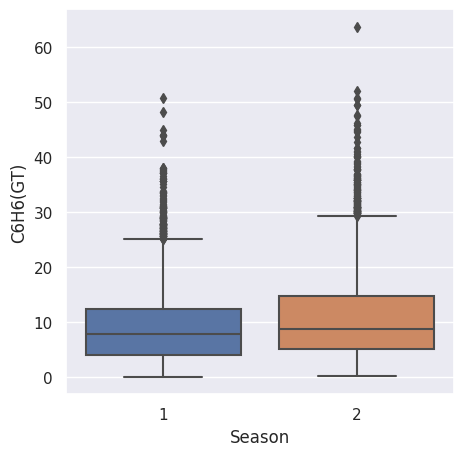

In [93]:
colname = "Season"
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

Визначимо пікові години

<Axes: xlabel='Hour', ylabel='C6H6(GT)'>

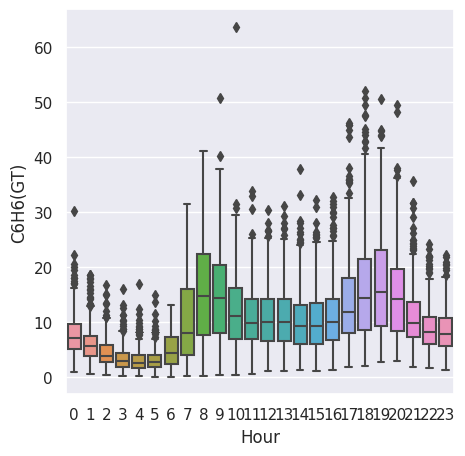

In [94]:
colname = "Hour"
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

In [101]:
def peak_hour(hour):
    if hour in [7, 8, 9, 10, 17, 18, 19, 20]:
        return 2
    else:
        return 1

df['Peak_hour'] = df['Hour'].apply(peak_hour)

<Axes: xlabel='Peak_hour', ylabel='C6H6(GT)'>

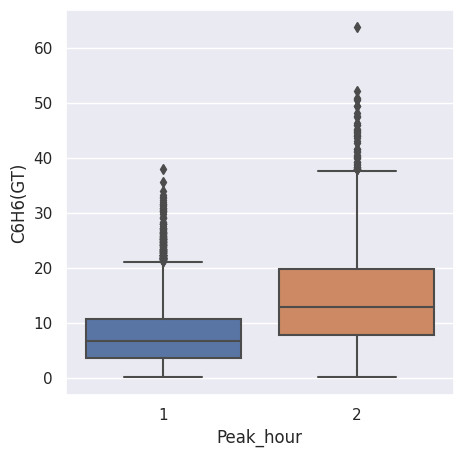

In [102]:
colname = "Peak_hour"
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9326 entries, 0 to 9356
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9326 non-null   datetime64[ns]
 1   Time           9326 non-null   object        
 2   CO(GT)         9326 non-null   float64       
 3   PT08.S1(CO)    9326 non-null   float64       
 4   NMHC(GT)       9326 non-null   float64       
 5   C6H6(GT)       9326 non-null   float64       
 6   PT08.S2(NMHC)  9326 non-null   float64       
 7   NOx(GT)        9326 non-null   float64       
 8   PT08.S3(NOx)   9326 non-null   float64       
 9   NO2(GT)        9326 non-null   float64       
 10  PT08.S4(NO2)   9326 non-null   float64       
 11  PT08.S5(O3)    9326 non-null   float64       
 12  T              9326 non-null   float64       
 13  RH             9326 non-null   float64       
 14  AH             9326 non-null   float64       
 15  DateTime       9326 n

# Побудуємо моделі

In [190]:
Y_df = df["C6H6(GT)"]
X_df = df.drop(labels=['C6H6(GT)', 'Date', 'Time', 'DateTime', ], inplace=False, axis=1)

In [191]:
X_df

CO(GT)  PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0        2.6       1360.0     150.0         1046.0    166.0        1056.0   
1        2.0       1292.0     112.0          955.0    103.0        1174.0   
2        2.2       1402.0      88.0          939.0    131.0        1140.0   
3        2.2       1376.0      80.0          948.0    172.0        1092.0   
4        1.6       1272.0      51.0          836.0    131.0        1205.0   
...      ...          ...       ...            ...      ...           ...   
9352     3.1       1314.0     150.0         1101.0    472.0         539.0   
9353     2.4       1163.0     150.0         1027.0    353.0         604.0   
9354     2.4       1142.0     150.0         1063.0    293.0         603.0   
9355     2.1       1003.0     150.0          961.0    235.0         702.0   
9356     2.2       1071.0     150.0         1047.0    265.0         654.0   

      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  Hour  Weekday  \
0       113.0        1692.0       1268.0  13.6  48.9  0.7578    18        6   
1        92.0        1559.0        972.0  13.3  47.7  0.7255    19        6   
2       114.0        1555.0       1074.0  11.9  54.0  0.7502    20        6   
3       122.0        1584.0       1203.0  11.0  60.0  0.7867    21        6   
4       116.0        1490.0       1110.0  11.2  59.6  0.7888    22        6   
...       ...           ...          ...   ...   ...     ...   ...      ...   
9352    190.0        1374.0       1729.0  21.9  29.3  0.7568    10        0   
9353    179.0        1264.0       1269.0  24.3  23.7  0.7119    11        0   
9354    175.0        1241.0       1092.0  26.9  18.3  0.6406    12        0   
9355    156.0        1041.0        770.0  28.3  13.5  0.5139    13        0   
9356    168.0        1129.0        816.0  28.5  13.1  0.5028    14        0   

      Weekday_revo  Month  Month_revo  Season  Peak_hour  
0                3     10           0       2          2  
1                3     10           0       2          2  
2                3     10           0       2          2  
3                3     10           0       2          1  
4                3     10           0       2          1  
...            ...    ...         ...     ...        ...  
9352             3      4           6       2          2  
9353             3      4           6       2          1  
9354             3      4           6       2          1  
9355             3      4           6       2          1  
9356             3      4           6       2          1  

[9326 rows x 19 columns]

In [192]:
X


array([[2.600e+00, 1.360e+03, 1.500e+02, ..., 0.000e+00, 2.000e+00,
        2.000e+00],
       [2.000e+00, 1.292e+03, 1.120e+02, ..., 0.000e+00, 2.000e+00,
        2.000e+00],
       [2.200e+00, 1.402e+03, 8.800e+01, ..., 0.000e+00, 2.000e+00,
        2.000e+00],
       ...,
       [2.400e+00, 1.142e+03, 1.500e+02, ..., 6.000e+00, 2.000e+00,
        1.000e+00],
       [2.100e+00, 1.003e+03, 1.500e+02, ..., 6.000e+00, 2.000e+00,
        1.000e+00],
       [2.200e+00, 1.071e+03, 1.500e+02, ..., 6.000e+00, 2.000e+00,
        1.000e+00]])

In [193]:
Y_df

0       11.9
1        9.4
2        9.0
3        9.2
4        6.5
        ... 
9352    13.5
9353    11.4
9354    12.4
9355     9.5
9356    11.9
Name: C6H6(GT), Length: 9326, dtype: float64

In [194]:
Y=Y_df

In [195]:
# split df to X and y and convert to matrixes
X = np.array(X_df)
y = np.array(Y_df).reshape(-1,1)
feature_names = df.columns[1:13]
feature_names

Index(['Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T'],
      dtype='object')

In [198]:
# split the data
folds = 10
test_size = 0.3
train_index = np.arange(0,int(len(X)*(1-test_size)))
test_index = np.arange(int(len(X)*(1-test_size)), len(X))
X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

In [227]:
# define model
model_lm = LinearRegression()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lm, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.805 (0.024)


In [231]:
model_lm.fit(X_train, y_train)

LinearRegression()

In [232]:
y_pred = model_lm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(mae)

1.779074507539232


Протестуємо модель

In [236]:
# define model
model_lasso = Lasso(alpha=0.05)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lasso, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.820 (0.022)


In [212]:
model_lasso.fit(X_train, y_train)
# define new data
row = X[1587]
# make a prediction
yhat = model_lasso.predict([row])
# summarize prediction
print('Predicted: %.3f' % yhat)
print('Real value: %.3f' % Y[1587])

Predicted: 10.559
Real value: 10.200


In [224]:
# define model
model_lasso = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = dict()
grid['alpha'] = np.arange(0.001, 0.02, 0.001)
# define search
search = GridSearchCV(model_lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('Mean MAE: %.3f' % abs(results.best_score_))
print('Config: %s' % results.best_params_)

Mean MAE: 0.805
Config: {'alpha': 0.004}


In [213]:
# define model
model_ridge = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_ridge, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.805 (0.024)


In [214]:
# define model
model_ridge = Ridge(alpha=0.05)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_ridge, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.805 (0.024)


In [208]:
model_ridge.fit(X_train, y_train)
# define new data
row = X[1080]
# make a prediction
yhat = model_ridge.predict([row])
# summarize prediction
print('Predicted: %.3f' % yhat)
print('Real value: %.3f' % Y[1080])

Predicted: 16.059
Real value: 15.700


Пошук параметрів

In [185]:
# polinomial model
xpoly = PolynomialFeatures(degree=2)
xpolyFeat = xpoly.fit_transform(X)


In [186]:
# define model
model_lm = LinearRegression()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lm, xpolyFeat, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.037 (0.001)


In [ ]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9326.000000  9326.000000  9326.000000  9326.000000    9326.000000   
mean      2.080806  1098.510079   156.743942    10.015462     938.070234   
std       1.294483   213.255277    67.168405     7.323169     262.054731   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.200000   941.000000   150.000000     4.600000     742.000000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.600000  1222.000000   150.000000    13.700000    1106.000000   
max       8.700000  2040.000000  1189.000000    63.700000    2214.000000   

          NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9326.00000   9326.000000  9326.000000   9326.000000  9326.000000   
mean    235.36232    834.434163   112.384516   1456.506541  1020.754235   
std     195.38905    252.221787    44.021078    339.933498   391.419866   
min       2.00000    322.000000     2.000000    551.000000   221.000000   
25%     112.00000    665.000000    85.000000   1241.000000   741.000000   
50%     180.00000    806.000000   109.000000   1463.000000   963.000000   
75%     285.00000    961.000000   133.000000   1662.750000  1257.000000   
max    1479.00000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         Hour      Weekday  \
count  9326.000000  9326.000000  9326.000000  9326.000000  9326.000000   
mean     18.299228    49.247341     1.024448    11.505576     3.009329   
std       8.672554    17.003130     0.396532     6.920980     2.006696   
min      -1.900000     9.200000     0.184700     0.000000     0.000000   
25%      12.000000    36.500000     0.745500     6.000000     1.000000   
50%      17.800000    49.600000     0.995400    12.000000     3.000000   
75%      24.100000    61.900000     1.298625    18.000000     5.000000   
max      44.600000    88.700000     2.231000    23.000000     6.000000   

       Weekday_revo        Month   Month_revo  
count   9326.000000  9326.000000  9326.000000  
mean       1.718529     6.342162     2.990671  
std        1.035982     3.470491     2.006696  
min        0.000000     1.000000     0.000000  
25%        1.000000     3.000000     1.000000  
50%        2.000000     6.000000     3.000000  
75%        3.000000     9.000000     5.000000  
max        3.000000    12.000000     6.000000

# Висновок

Найефективнішою виявилась поліноміальна модель за рахунок показника C6H6(GT)